In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

In [2]:
def generate_random_hermitian_matrix(N, seed, flag):
    np.random.seed(seed)
    
    if flag == 0:
        # Generate using standard normal distribution
        real_part = np.random.randn(N, N)
        imag_part = np.random.randn(N, N)
    elif flag == 1:
        # Generate values between -1 and 1
        real_part = np.random.uniform(-1, 1, (N, N))
        imag_part = np.random.uniform(-1, 1, (N, N))
    else:
        raise ValueError("Invalid flag value. Use 0 for normal distribution or 1 for [-1, 1].")
    
    # Combine real and imaginary parts to form a complex matrix
    A = real_part + 1j * imag_part
    
    # Make the matrix Hermitian
    A = np.tril(A) + np.tril(A, -1).T.conj()  # Lower triangle + conjugate transpose of upper
    
    return A


def compute_normalized_spacings(N, seed, flag):
    # Generate Hermitian matrix and compute eigenvalues
    A = generate_random_hermitian_matrix(N, seed, flag)
    eigenvalues = np.linalg.eigh(A)[0]  # Sorted real eigenvalues
    
    # Compute spacings and normalize by mean spacing
    spacings = np.diff(eigenvalues)
    avg_spacing = np.mean(spacings)
    normalized_spacings = spacings / avg_spacing
    return A, eigenvalues, normalized_spacings

def calculate_Ps_distribution(N, num_matrices, N_bins, flag):
    all_normalized_spacings = []
    
    # Accumulate normalized spacings from multiple random matrices
    for i in range(num_matrices):
        seed = i  # Use a different seed for each matrix
        A, eigenvalues, normalized_spacings = compute_normalized_spacings(N, seed, flag)
        all_normalized_spacings.extend(normalized_spacings)
    
    # Convert to numpy array
    all_normalized_spacings = np.array(all_normalized_spacings)
    
    # Range of normalized spacings
    DeltaS = np.max(all_normalized_spacings) - np.min(all_normalized_spacings)
    
    # Create bins and count occurrences in each bin
    counts, bin_edges = np.histogram(all_normalized_spacings, bins=N_bins, range=(0, DeltaS))


    # Total number of spacings
    N_tot = len(all_normalized_spacings)
    
    # Compute P(s) for each bin
    P_s = counts / (N_tot)
    
    # Bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, P_s

def plot_distr_and_fit(bin_centers, P_s, num_matrices, N, flag, fitted_P_s):

    if flag == 0:
        msg = "# Generate using standard normal distribution"
    elif flag == 1:
        msg = "# Generate values between -1 and 1"
    else:
        raise ValueError("Invalid flag value. Use 0 for normal distribution, or 1 for [-1, 1].")
    

    # sns.set_theme(style='whitegrid')

    plt.figure(figsize=(10, 6))
    
    plt.plot(bin_centers, P_s, label='$P(s)$', color='blue', linewidth=2)
    plt.plot(bin_centers, fitted_P_s, label='Fitted $P(s)$', color='red', linestyle='--', linewidth=2)

    # Add a title with improved formatting
    plt.title(f'Distribution of Normalized Spacings $P(s)$\nwith {num_matrices} Matrices of Size {N}\n{msg}', 
              fontsize=16)

    # Set labels with larger font sizes
    plt.xlabel('Normalized Spacing $s$', fontsize=14)
    plt.ylabel('$P(s)$', fontsize=14)

    # Add grid for better readability
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)

    # Add a legend with a better location
    plt.legend(fontsize=12, loc='upper right')

    # Set x and y limits if needed for better visibility
    plt.xlim(left=0)  # Adjust this according to your data range
    plt.ylim(bottom=0)  # Adjust this according to your data range

    # Show the plot with a tighter layout
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()



def target_function(s, a, b, alpha, beta):
    """Fitting function P(s) = a * (s ** alpha) * exp(b * (s ** beta))"""
    return a * (s ** alpha) * np.exp(b * (s ** beta))

def fitting(bin_centers, P_s, counts, flag):
    # Initial guesses for parameters a, b, alpha, and beta
    initial_guess = [1, -1, 1, 1]
    
    # Perform curve fitting
    params, _ = curve_fit(target_function, bin_centers, P_s, p0=initial_guess, maxfev=5000)
    a, b, alpha, beta = params
    
    # Print fitted parameters

    if flag == 0:
        msg = "# Generate using standard normal distribution"
    elif flag == 1:
        msg = "# Generate values between -1 and 1"
    else:
        raise ValueError("Invalid flag value. Use 0 for normal distribution, or 1 for [-1, 1].")

    print(msg)
    print(f"Fitted parameters:\n a = {a:.4f}, b = {b:.4f}, alpha = {alpha:.4f}, beta = {beta:.4f}")
    
    # Generate fitted values for plotting
    fitted_P_s = target_function(bin_centers, a, b, alpha, beta)

    # Calculate chi-square
    # Approximate uncertainties as sqrt of counts (Poisson uncertainty)
    uncertainties = np.sqrt(counts)
    # Avoid division by zero in case of zero counts
    uncertainties[uncertainties == 0] = 1  # Assign a minimal uncertainty if count is zero
    
    chi_square = np.sum(((P_s - fitted_P_s) ** 2) / (uncertainties ** 2))

    print(f"Chi-square: {chi_square}")
    print('\n')
    
    return a, b, alpha, beta, chi_square, fitted_P_s

### Exercise 2.

In [3]:
N_size = 5
seed = 12345
flag = 0

A, eigenvalues, norm_spacings = compute_normalized_spacings(N_size, seed, flag)
print("Matrix is ", A)
print("ordered eigenvalues are ", eigenvalues)
print("normalized spacings are ", norm_spacings)

Matrix is  [[-0.20470766+0.12412128j  1.39340583+0.71354399j  1.00718936-0.56014529j
   0.88642934+2.35941881j -0.53974145-0.28634975j]
 [ 1.39340583-0.71354399j  0.09290788-0.83115354j -1.29622111+1.26593449j
  -2.00163731+0.19954296j  0.47698501-0.37798411j]
 [ 1.00718936+0.56014529j -1.29622111-1.26593449j  0.27499163+0.11982712j
  -0.37184254+1.54199553j  3.24894392+0.75388653j]
 [ 0.88642934-2.35941881j -2.00163731-0.19954296j -0.37184254-1.54199553j
   1.66902531-0.97073591j -1.02122752-0.33128565j]
 [-0.53974145+0.28634975j  0.47698501+0.37798411j  3.24894392-0.75388653j
  -1.02122752+0.33128565j -0.5770873 +1.34974221j]]
ordered eigenvalues are  [-4.89251946 -2.78728517  0.73837735  2.79516125  5.40139588]
normalized spacings are  [0.81804997 1.36999864 0.79922317 1.01272822]


### Exercise 3

In [4]:
# Example usage:
N = 1000  # Size of each matrix
num_matrices = 20  # Number of random matrices to accumulate data
N_bins = 100  # Number of bins for the histogram
flag = np.array([0,1])

# bin_centers, P_s = calculate_Ps_distribution(N, num_matrices, N_bins, flag)
# plot_Ps_distribution(bin_centers, P_s, num_matrices, N, flag)


Fitting for flag 0...
# Generate using standard normal distribution
Fitted parameters:
 a = 1.7443, b = -3.1923, alpha = 2.8213, beta = 1.2542
Chi-square: 7.524011965807658e-05


Fitting for flag 1...
# Generate values between -1 and 1
Fitted parameters:
 a = 2.8525, b = -3.2765, alpha = 2.8765, beta = 1.2375
Chi-square: 0.0001199182216527659


Best flag: 0
Best chi-square value: 7.524011965807658e-05
Best parameters: a = 1.7443, b = -3.1923, alpha = 2.8213, beta = 1.2542


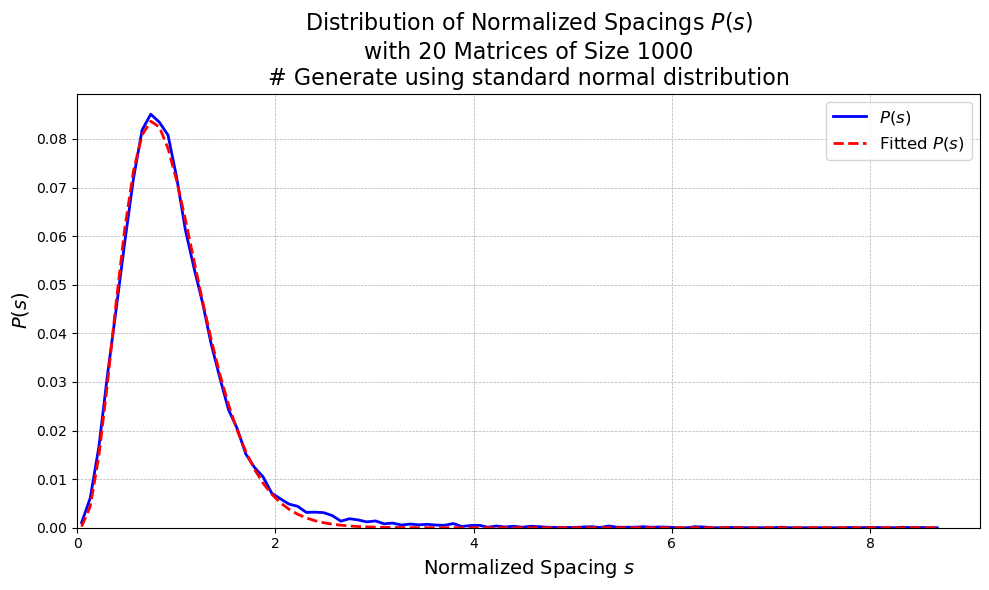

In [5]:
# Initialize variables to keep track of the best chi-square value and corresponding flag
best_chi_square = float('inf')
best_flag = None
best_params = None
best_fit_P_s = None
best_bin_centers = None
best_P_s = None

# Loop through each flag and fit the distribution
for i in flag:
    bin_centers, P_s = calculate_Ps_distribution(N, num_matrices, N_bins, i)
    counts, _ = np.histogram(bin_centers, bins=N_bins)

    print(f"Fitting for flag {i}...")
    a, b, alpha, beta, chi_square, fitted_P_s = fitting(bin_centers, P_s, counts, i)
    
    # Check if this chi-square is the best one so far
    if chi_square < best_chi_square:
        best_chi_square = chi_square
        best_flag = i
        best_params = (a, b, alpha, beta)
        best_fit_P_s = fitted_P_s
        best_bin_centers = bin_centers
        best_P_s = P_s

# After finding the best flag, print the result
print(f"Best flag: {best_flag}")
print(f"Best chi-square value: {best_chi_square}")
print(f"Best parameters: a = {best_params[0]:.4f}, b = {best_params[1]:.4f}, alpha = {best_params[2]:.4f}, beta = {best_params[3]:.4f}")

# Plot the graph for the best flag
plot_distr_and_fit(best_bin_centers, best_P_s, num_matrices, N, best_flag, best_fit_P_s)
